In [34]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math
import json
from scipy import stats
from pathlib import Path
from statistics import mean
from collections import Counter

import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
# plt.rc('font', family='Times New Roman')

# plot set start
sns.set(font='Times New Roman', font_scale=1.5,style='white')
# sns.set_style('white')

In [35]:
def separateAllExpData(expDir: Path):
    results = []
    for dirPath in expDir.glob('*'):
        print(dirPath)
        
        idParas = dirPath.name.split('_slvr')
        id = idParas[0]
        
        solverNameParas = idParas[-1].split('_ds')
        solverName = solverNameParas[0]
        
        downsampleParas = solverNameParas[-1].split('_L')
        downsample = downsampleParas[0]
        
        LSizeParas = downsampleParas[-1].split('_k')
        LSize = LSizeParas[0]
        
        kmaxParas = LSizeParas[-1].split('_ch')
        kmax = kmaxParas[0]
        # print(kmax)

        chunkSizeParas = kmaxParas[-1].split('_r')
        chunkSize = chunkSizeParas[0]
        
        rrParas = chunkSizeParas[-1].split('_thr')
        rr = rrParas[0]

        # threshold_coverageParas = rrParas[-1].split('_pose')
        threshold_coverage = rrParas[1]

        filePara = [id,solverName,downsample,LSize,kmax,chunkSize,rr,threshold_coverage]
        
        numOfFile = len([i for i in (dirPath/'results').glob('*')])   

        for fileNum in range(numOfFile):
            result = []  
            filePath = dirPath/'results'/f'log_{fileNum}.json'
            with open(filePath) as f:
                data = json.load(f)
            
            numOfSourceViews = len(data['sol'])
            numOfCamera = Counter(data['sol']).get(1.0)
            if numOfCamera == None:
                numOfCamera = 0

            for tvNum in range(numOfSourceViews):
                coverage_estimated_first_order_diff = data['coverage_estimated_first_order_diff'][tvNum]
                coverage_estimated_second_order_diff = data['coverage_estimated_second_order_diff'][tvNum]
                result = filePara + [fileNum, numOfSourceViews, numOfCamera, tvNum, coverage_estimated_first_order_diff, coverage_estimated_second_order_diff]
                results.append(result)

    allDf = pd.DataFrame(results)
    allDf.to_csv(f'{expDir.stem}_allResults.csv', header=['id','solverName','downsample','LSize','kmax','chunkSize','rr','threshold_coverage','fileNum','numOfSourceViews','numOfCamera','tvNum','coverage_estimated_first_order_diff','coverage_estimated_second_order_diff'],index=None)

In [36]:
def separateAllExpData_withLog(expDir: Path):
    results = []
    for dirPath in expDir.glob('*'):
        print(dirPath)
        
        idParas = dirPath.name.split('_slvr')
        id = idParas[0]
        
        solverNameParas = idParas[-1].split('_ds')
        solverName = solverNameParas[0]
        
        downsampleParas = solverNameParas[-1].split('_L')
        downsample = downsampleParas[0]
        
        LSizeParas = downsampleParas[-1].split('_k')
        LSize = LSizeParas[0]
        
        kmaxParas = LSizeParas[-1].split('_ch')
        kmax = kmaxParas[0]
        # print(kmax)

        chunkSizeParas = kmaxParas[-1].split('_r')
        chunkSize = chunkSizeParas[0]
        
        rrParas = chunkSizeParas[-1].split('_thr')
        rr = rrParas[0]

        # threshold_coverageParas = rrParas[-1].split('_pose')
        threshold_coverage = rrParas[1]

        filePara = [id,solverName,downsample,LSize,kmax,chunkSize,rr,threshold_coverage]
        
        numOfFile = len([i for i in (dirPath/'results').glob('*')])   

        for filePath in (dirPath/'results').glob('log_*.json'):
            fileNum = (filePath.stem).split('_')[-1]
            result = []

            # filePath = dirPath/'results'/f'log_{fileNum}.json'
            with open(filePath) as f:
                data = json.load(f)
            
            numOfSourceViews = len(data['sol'])
            numOfCamera = Counter(data['sol']).get(1.0)
            if numOfCamera == None:
                numOfCamera = 0

            for tvNum in range(numOfSourceViews):
                real_coverage = data['coverage'][tvNum]
                coverage_estimated_first_order_diff = data['coverage_estimated_first_order_diff'][tvNum]
                coverage_estimated_second_order_diff = data['coverage_estimated_second_order_diff'][tvNum]
                result = filePara + [numOfSourceViews, numOfCamera, tvNum, real_coverage, coverage_estimated_first_order_diff, coverage_estimated_second_order_diff, fileNum]
                results.append(result)

    allDf = pd.DataFrame(results)
    allDf.to_csv(f'{expDir.stem}_allResults.csv', header=['id','solverName','downsample','LSize','kmax','chunkSize','rr','threshold_coverage','numOfSourceViews','numOfCamera','tvNum','real_coverage','coverage_estimated_first_order_diff','coverage_estimated_second_order_diff','log'],index=None)

In [37]:
def merge_results(coverageResultFilePath, qualityResultFilePath):
    coverageDf = pd.read_csv(coverageResultFilePath)
    qualityDf = pd.read_csv(qualityResultFilePath)
    
    for index in coverageDf.index:
        df = qualityDf
        df = df.loc[df['id'] == coverageDf.loc[index, 'id']]
        df = df.loc[df['kmax'] == coverageDf.loc[index, 'kmax']]
        df = df.loc[df['log'] == coverageDf.loc[index, 'log']]
        df = df.loc[df['Frame'] == coverageDf.loc[index, 'tvNum']]
        numOfFrame = df.shape[0]
        
        # print(numOfFrame)
        # print(index)
        if numOfFrame == 1:
            psnr = df["psnr_y"].mean()
            ssim = df["float_ssim"].mean()
            vmaf = df["vmaf"].mean()
            # print(psnr, ssim, vmaf)
            coverageDf.loc[index, 'psnr_y'] = psnr
            coverageDf.loc[index, 'float_ssim'] = ssim
            coverageDf.loc[index, 'vmaf'] = vmaf
        
        else:
            psnr = df["psnr_y"].mean()
            ssim = df["float_ssim"].mean()
            vmaf = df["vmaf"].mean()
            coverageDf.loc[index, 'psnr_y'] = psnr
            coverageDf.loc[index, 'float_ssim'] = ssim
            coverageDf.loc[index, 'vmaf'] = vmaf
            # coverageDf.loc[index, 'psnr_y'] = -1
            # coverageDf.loc[index, 'float_ssim'] = -1
            # coverageDf.loc[index, 'vmaf'] = -1
            print(f'id:{coverageDf.loc[index, "id"]}, log:{coverageDf.loc[index, "log"]}, numOfFrame:{numOfFrame}, error')
        
    coverageDf.to_csv(f'{coverageResultFilePath.stem}_merge.csv',index=None)


In [38]:
def calSum(arr: list):
    sum = 0
    for i in arr:
        sum = sum + abs(float(i))
    return sum

In [39]:
def MSEPlot(filePath: Path):
    '''
    Get all the average result value from different id
    '''
    doplot = True
    expName = filePath.stem.split('_allResults')[0]
    savePath = Path(f'./img/MSEPlot')
    
    df = pd.read_csv(filePath)
    resultDf = df
    resultDf['coverage_estimated_first_order_diff'] = resultDf['coverage_estimated_first_order_diff'].mul(resultDf['coverage_estimated_first_order_diff'])
    resultDf['coverage_estimated_second_order_diff'] = resultDf['coverage_estimated_second_order_diff'].mul(resultDf['coverage_estimated_second_order_diff'])
    
        
    # first order
    ax = sns.lineplot(x='numOfCamera', y=f'coverage_estimated_first_order_diff', hue='kmax',data=resultDf, palette=sns.color_palette("tab10",n_colors=2))
    ax.set(xlabel="numOfCamera", ylabel=f"First Order MSE")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_firstOrder_numOfCam'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()


    # second order
    ax = sns.lineplot(x='numOfCamera', y=f'coverage_estimated_second_order_diff', hue='kmax',data=resultDf, palette=sns.color_palette("tab10",n_colors=2))
    ax.set(xlabel="numOfCamera", ylabel=f"Second Order MSE")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,91,30))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_secondOrder_numOfCam'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # psnr_y
    ax = sns.lineplot(x='numOfCamera', y=f'psnr_y', hue='kmax',data=resultDf, palette=sns.color_palette("tab10",n_colors=2))
    ax.set(xlabel="numOfCamera", ylabel=f"PSNR")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,91,30))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_psnr_numOfCam'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # float_ssim
    ax = sns.lineplot(x='numOfCamera', y=f'float_ssim', hue='kmax',data=resultDf, palette=sns.color_palette("tab10",n_colors=2))
    ax.set(xlabel="numOfCamera", ylabel=f"SSIM")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,91,30))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_ssim_numOfCam'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # vmaf
    ax = sns.lineplot(x='numOfCamera', y=f'vmaf', hue='kmax',data=resultDf, palette=sns.color_palette("tab10",n_colors=2))
    ax.set(xlabel="numOfCamera", ylabel=f"VMAF")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,91,30))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_vmaf_numOfCam'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()


In [40]:
def allCoverageResultAverage(filePath: Path):
    '''
    Get all the average result value from different id
    '''
    expName = filePath.stem.split('_allResults')[0]
    
    doplot = True

    df = pd.read_csv(filePath)
    resultDf = df

    savePath = Path(f'./img/allCoverageResultAverage')

    # first order
    ax = sns.barplot(x='kmax', y=f'averageFirstOrderDiff', data=resultDf, palette=palette)
    ax.set(xlabel="kmax", ylabel=f"First Order Difference")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,91,30))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_firstOrder'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # second order
    ax = sns.barplot(x='kmax', y=f'averageSecondOrderDiff', data=resultDf, palette=palette)
    ax.set(xlabel="kmax", ylabel=f"Second Order Difference")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,91,30))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_secondOrder'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()


In [41]:
def qualityMSEPlot(filePath):
    
    doplot = True
    expName = filePath.stem.split('_allResults')[0]
    savePath = Path(f'./img/qualityMSEPlot')
    
    df = pd.read_csv(filePath)
    resultDf = df
    resultDf['coverage_estimated_first_order_diff'] = resultDf['coverage_estimated_first_order_diff'].mul(resultDf['coverage_estimated_first_order_diff'])
    resultDf['coverage_estimated_second_order_diff'] = resultDf['coverage_estimated_second_order_diff'].mul(resultDf['coverage_estimated_second_order_diff'])
    
    # print(pd.unique(df['id']))
    # print(pd.unique(df['kmax']))
    # print(pd.unique(df['kmax']))

    resultsList = []

    for id in pd.unique(df['id']):
        idDf = resultDf.loc[resultDf['id'] == id]
        for kmax in pd.unique(idDf['kmax']):
            kmaxDf = idDf.loc[idDf['kmax'] == kmax]
            for log in pd.unique(kmaxDf['log']):
                logDf = kmaxDf.loc[kmaxDf['log'] == log]
                # print(pd.unique(logDf['vmaf']))
                numOfCamera = logDf['numOfCamera'].mean()
                coverage = logDf['real_coverage'].mean()
                firstOrderMSE = logDf['coverage_estimated_first_order_diff'].mean()
                secondOrderMSE = logDf['coverage_estimated_second_order_diff'].mean()
                psnr_value = logDf['psnr_y'].mean()
                mse_value = 255*255/(math.pow(10, psnr_value/10))
                ssim_value = logDf['float_ssim'].mean()
                vmaf_value = logDf['vmaf'].mean()
                resultsList.append([id,kmax,log,coverage,firstOrderMSE,secondOrderMSE,psnr_value,ssim_value,vmaf_value,numOfCamera,mse_value])
    
    qualityDf = pd.DataFrame(resultsList, columns=['id','kmax','log','real_coverage','firstOrderMSE','secondOrderMSE','psnr_value','ssim_value','vmaf_value','numOfCamera','mse_value'])
    

    # # first order
    # ax = sns.lineplot(x='firstOrderMSE', y=f'psnr_value', hue='kmax',data=qualityDf, palette=sns.color_palette("tab10",n_colors=2))
    # ax.set(xlabel="First Order Coverage MSE", ylabel=f"PSNR")
    # # plt.legend(title="")
    # # plt.xticks(rotation=-90)
    # # plt.xticks(range(0,11,1))
    # # plt.xlim((0,90))
    # # plt.ylim((0,33))

    # savePath.mkdir(parents=True, exist_ok=True)
    # saveFilename = savePath/f'{expName}_diffKmax_firstOrder'
    
    # if doplot:
    #     # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #     plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    # plt.show()

    # print(pd.unique(qualityDf['kmax']))
    # for kmax in pd.unique(qualityDf['kmax']):
    #     kmaxQualityDf = qualityDf.loc[qualityDf['kmax'] == kmax]
    #     # first order
    #     ax = sns.lineplot(x='firstOrderMSE', y=f'psnr_value',data=kmaxQualityDf, palette=sns.color_palette("tab10",n_colors=1))
    #     ax.set(xlabel="First Order Coverage MSE", ylabel=f"PSNR")
    #     # plt.title(f"kmax = {kmax}")
    #     # plt.xticks(rotation=-90)
    #     # plt.xticks(range(0,11,1))
    #     # plt.xlim((0,90))
    #     # plt.ylim((0,33))

    #     savePath.mkdir(parents=True, exist_ok=True)
    #     saveFilename = savePath/f'{expName}_diffKmax_firstOrder_kmax{kmax}'
        
    #     if doplot:
    #         # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #         plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    #     plt.show()
    
    # # second order
    # ax = sns.lineplot(x='secondOrderMSE', y=f'psnr_value', hue='kmax',data=qualityDf, palette=sns.color_palette("tab10",n_colors=2))
    # ax.set(xlabel="Second Order Coverage MSE", ylabel=f"PSNR")
    # # plt.legend(title="")
    # # plt.xticks(rotation=-90)
    # # plt.xticks(range(0,11,1))
    # # plt.xlim((0,90))
    # # plt.ylim((0,33))

    # savePath.mkdir(parents=True, exist_ok=True)
    # saveFilename = savePath/f'{expName}_diffKmax_secondOrder_kmax'
    
    # if doplot:
    #     # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #     plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    # plt.show()

    # print(pd.unique(qualityDf['kmax']))
    # for kmax in pd.unique(qualityDf['kmax']):
    #     kmaxQualityDf = qualityDf.loc[qualityDf['kmax'] == kmax]
    #     # first order
    #     ax = sns.lineplot(x='secondOrderMSE', y=f'psnr_value',data=kmaxQualityDf, palette=sns.color_palette("tab10",n_colors=1))
    #     ax.set(xlabel="Second Order Coverage MSE", ylabel=f"PSNR")
    #     # plt.title(f"kmax = {kmax}")
    #     # plt.xticks(rotation=-90)
    #     # plt.xticks(range(0,11,1))
    #     # plt.xlim((0,90))
    #     # plt.ylim((0,33))

    #     savePath.mkdir(parents=True, exist_ok=True)
    #     saveFilename = savePath/f'{expName}_diffKmax_secondOrder_kmax{kmax}'
        
    #     if doplot:
    #         # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #         plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    #     plt.show()

    # # real coverage & quality
    # ax = sns.lineplot(x='real_coverage', y=f'psnr_value', hue='kmax',data=qualityDf, palette=sns.color_palette("tab10",n_colors=2))
    # ax.set(xlabel="Real Coverage", ylabel=f"PSNR")
    # # plt.legend(title="")
    # # plt.xticks(rotation=-90)
    # # plt.xticks(range(0,11,1))
    # # plt.xlim((0,90))
    # # plt.ylim((0,33))

    # savePath.mkdir(parents=True, exist_ok=True)
    # saveFilename = savePath/f'{expName}_diffKmax_realCoverage'
    
    # if doplot:
    #     # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #     plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    # plt.show()

    # print(pd.unique(qualityDf['kmax']))
    # for kmax in pd.unique(qualityDf['kmax']):
    #     kmaxQualityDf = qualityDf.loc[qualityDf['kmax'] == kmax]
    #     # first order
    #     ax = sns.lineplot(x='real_coverage', y=f'psnr_value',data=kmaxQualityDf, palette=sns.color_palette("tab10",n_colors=1))
    #     ax.set(xlabel="Real Coverage", ylabel=f"PSNR")
    #     # plt.title(f"kmax = {kmax}")
    #     # plt.xticks(rotation=-90)
    #     # plt.xticks(range(0,11,1))
    #     # plt.xlim((0,90))
    #     # plt.ylim((0,33))

    #     savePath.mkdir(parents=True, exist_ok=True)
    #     saveFilename = savePath/f'{expName}_diffKmax_realCoverage_kmax{kmax}'
        
    #     if doplot:
    #         # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #         plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    #     plt.show()

    # # =======================================================================================================
    # # first order & real coverage
    # ax = sns.lineplot(x='firstOrderMSE', y=f'real_coverage', hue='kmax',data=qualityDf, palette=sns.color_palette("tab10",n_colors=2))
    # ax.set(xlabel="First Order Coverage MSE", ylabel=f"Real Coverage")
    # # plt.legend(title="")
    # # plt.xticks(rotation=-90)
    # # plt.xticks(range(0,11,1))
    # # plt.xlim((0,90))
    # # plt.ylim((0,33))

    # savePath.mkdir(parents=True, exist_ok=True)
    # saveFilename = savePath/f'{expName}_diffKmax_realCoverage_firstOrderMSE'
    
    # if doplot:
    #     # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #     plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    # plt.show()

    # print(pd.unique(qualityDf['kmax']))
    # for kmax in pd.unique(qualityDf['kmax']):
    #     kmaxQualityDf = qualityDf.loc[qualityDf['kmax'] == kmax]
    #     # first order
    #     ax = sns.lineplot(x='firstOrderMSE', y=f'real_coverage',data=kmaxQualityDf, palette=sns.color_palette("tab10",n_colors=1))
    #     ax.set(xlabel="First Order Coverage MSE", ylabel=f"Real Coverage")
    #     # plt.title(f"kmax = {kmax}")
    #     # plt.xticks(rotation=-90)
    #     # plt.xticks(range(0,11,1))
    #     # plt.xlim((0,90))
    #     # plt.ylim((0,33))

    #     savePath.mkdir(parents=True, exist_ok=True)
    #     saveFilename = savePath/f'{expName}_diffKmax_realCoverage_firstOrderMSE_kmax{kmax}'
        
    #     if doplot:
    #         # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #         plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    #     plt.show()

    # # =======================================================================================================
    # # second order & real coverage
    # ax = sns.lineplot(x='secondOrderMSE', y=f'real_coverage', hue='kmax',data=qualityDf, palette=sns.color_palette("tab10",n_colors=2))
    # ax.set(xlabel="Second Order Coverage MSE", ylabel=f"Real Coverage")
    # # plt.legend(title="")
    # # plt.xticks(rotation=-90)
    # # plt.xticks(range(0,11,1))
    # # plt.xlim((0,90))
    # # plt.ylim((0,33))

    # savePath.mkdir(parents=True, exist_ok=True)
    # saveFilename = savePath/f'{expName}_diffKmax_realCoverage_secondOrderMSE'
    
    # if doplot:
    #     # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #     plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    # plt.show()

    # print(pd.unique(qualityDf['kmax']))
    # for kmax in pd.unique(qualityDf['kmax']):
    #     kmaxQualityDf = qualityDf.loc[qualityDf['kmax'] == kmax]
    #     # first order
    #     ax = sns.lineplot(x='secondOrderMSE', y=f'real_coverage',data=kmaxQualityDf, palette=sns.color_palette("tab10",n_colors=1))
    #     ax.set(xlabel="Second Order Coverage MSE", ylabel=f"Real Coverage")
    #     # plt.title(f"kmax = {kmax}")
    #     # plt.xticks(rotation=-90)
    #     # plt.xticks(range(0,11,1))
    #     # plt.xlim((0,90))
    #     # plt.ylim((0,33))

    #     savePath.mkdir(parents=True, exist_ok=True)
    #     saveFilename = savePath/f'{expName}_diffKmax_realCoverage_secondOrderMSE_kmax{kmax}'
        
    #     if doplot:
    #         # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #         plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #         # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    #     plt.show()

    # # first order & real coverage
    # ax = sns.lineplot(x='numOfCamera', y=f'real_coverage', hue='kmax',data=qualityDf, palette=sns.color_palette("tab10",n_colors=2))
    # ax.set(xlabel="numOfCamera", ylabel=f"Real Coverage")
    # # plt.legend(title="")
    # # plt.xticks(rotation=-90)
    # # plt.xticks(range(0,11,1))
    # # plt.xlim((0,90))
    # # plt.ylim((0,33))

    # savePath.mkdir(parents=True, exist_ok=True)
    # saveFilename = savePath/f'{expName}_diffKmax_realCoverage_numOfCamera'
    
    # if doplot:
    #     # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
    #     plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
    #     # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    # plt.show()



In [42]:
def newQualityMSEScatterPlot(filePath):
    
    doplot = True
    expName = filePath.stem.split('_allResults')[0]
    savePath = Path(f'./img/newQualityMSEScatterPlot')
    
    df = pd.read_csv(filePath)
    resultDf = df
    resultDf['coverage_estimated_first_order_diff'] = resultDf['coverage_estimated_first_order_diff'].mul(resultDf['coverage_estimated_first_order_diff'])
    resultDf['coverage_estimated_second_order_diff'] = resultDf['coverage_estimated_second_order_diff'].mul(resultDf['coverage_estimated_second_order_diff'])
    
    # print(pd.unique(df['id']))
    # print(pd.unique(df['kmax']))
    # print(pd.unique(df['kmax']))

    resultsList = []

    for id in pd.unique(df['id']):
        idDf = resultDf.loc[resultDf['id'] == id]
        for kmax in pd.unique(idDf['kmax']):
            kmaxDf = idDf.loc[idDf['kmax'] == kmax]
            for log in pd.unique(kmaxDf['log']):
                logDf = kmaxDf.loc[kmaxDf['log'] == log]
                # print(pd.unique(logDf['vmaf']))
                numOfCamera = logDf['numOfCamera'].mean()
                # coverage = math.log(logDf['real_coverage'].mean(),10)
                coverage = logDf['real_coverage'].mean()
                firstOrderMSE = logDf['coverage_estimated_first_order_diff'].mean()
                secondOrderMSE = logDf['coverage_estimated_second_order_diff'].mean()
                psnr_value = logDf['psnr_y'].mean()
                # mse_value = 255*255/(math.pow(10, psnr_value/10))
                mse_value = math.log(255*255/(math.pow(10, psnr_value/10)),10)
                ssim_value = logDf['float_ssim'].mean()
                vmaf_value = logDf['vmaf'].mean()
                resultsList.append([id,kmax,log,coverage,firstOrderMSE,secondOrderMSE,psnr_value,ssim_value,vmaf_value,numOfCamera,mse_value])
    
    qualityDf = pd.DataFrame(resultsList, columns=['id','kmax','log','real_coverage','firstOrderMSE','secondOrderMSE','psnr_value','ssim_value','vmaf_value','numOfCamera','mse_value'])
    
    x = qualityDf['mse_value']
    y = qualityDf['real_coverage']
    print(f'Pearson: {x.corr(y)}')
    print(f"Spearman: {x.corr(y,method='spearman')}")
    print(f"Kendall: {x.corr(y,method='kendall')}")


    # mse & real coverage
    ax = sns.scatterplot(x='mse_value', y=f'real_coverage', hue='kmax',data=qualityDf, palette=sns.color_palette("tab10",n_colors=2))
    ax.set(xlabel="log(quality MSE)", ylabel=f"Real coverage")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    savePath.mkdir(parents=True, exist_ok=True)
    saveFilename = savePath/f'{expName}_diffKmax_realCoverage_MSE'
    
    if doplot:
        # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()
    
    for kmax in pd.unique(qualityDf['kmax']):
        kmaxQualityDf = qualityDf.loc[qualityDf['kmax'] == kmax]

        x = kmaxQualityDf['mse_value']
        y = kmaxQualityDf['real_coverage']
        print(f'Pearson: {x.corr(y)}')
        print(f"Spearman: {x.corr(y,method='spearman')}")
        print(f"Kendall: {x.corr(y,method='kendall')}")
        # first order
        ax = sns.scatterplot(x='mse_value', y=f'real_coverage',data=kmaxQualityDf, palette=sns.color_palette("tab10",n_colors=1))
        ax.set(xlabel="log(quality MSE)", ylabel=f"Real coverage")
        # plt.title(f"kmax = {kmax}")
        # plt.xticks(rotation=-90)
        # plt.xticks(range(0,11,1))
        # plt.xlim((0,90))
        # plt.ylim((0,33))

        savePath.mkdir(parents=True, exist_ok=True)
        saveFilename = savePath/f'{expName}_diffKmax_realCoverage_MSE_kmax{kmax}'
        
        if doplot:
            # plt.savefig(f'{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
            plt.savefig(f'{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
            # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
            # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
        plt.show()

In [43]:
def qualityAndCoverage(filePath: Path):

    doplot = True
    expName = filePath.stem.split('_allResults')[0]
    savePath = Path(f'./img/qualityAndCoverage')
    savePath.mkdir(parents=True,exist_ok=True)
    
    df = pd.read_csv(filePath)
    resultDf = df
    resultDf['mse'] = (resultDf['psnr_y'].apply(lambda x: math.log(255*255/(math.pow(10, x/10)),10))).round(2)
    resultDf['psnr_y'] = resultDf['psnr_y'].round(2)
    resultDf['real_coverage'] = resultDf['real_coverage'].round(2)

    # ========================= the cdf of the coverage data =========================
    print(f'Number of data: {resultDf.shape[0]}')
    ax = sns.ecdfplot(data=resultDf, x="real_coverage")
    ax.set(xlabel="Real Coverage (percent)", ylabel=f"Proportion")
    saveFilename = f'{expName}_cdf_realCoverage'
    
    if doplot:
        plt.savefig(f'{savePath}/{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{savePath}/{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # ========================= psnr_y & real coverage =========================
    # scatterplot
    x = resultDf['real_coverage']
    y = resultDf['psnr_y']
    print(f'Pearson: {x.corr(y)}')
    print(f"Spearman: {x.corr(y,method='spearman')}")
    print(f"Kendall: {x.corr(y,method='kendall')}")

    ax = sns.scatterplot(x='real_coverage', y=f'psnr_y', data=resultDf, palette=sns.color_palette("tab10",n_colors=1))
    ax.set(xlabel="Real coverage (percent)", ylabel=f"Quality in PSNR (dB)")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    saveFilename = f'{expName}_scatterPlot_psnr_realCoverage'
    
    if doplot:
        plt.savefig(f'{savePath}/{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{savePath}/{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # lineplot
    ax = sns.lineplot(x='real_coverage', y=f'psnr_y', data=resultDf, palette=sns.color_palette("tab10",n_colors=1))
    ax.set(xlabel="Real coverage (percent)", ylabel=f"Quality in PSNR (dB)")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    saveFilename = f'{expName}_linePlot_psnr_realCoverage'
    
    if doplot:
        plt.savefig(f'{savePath}/{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{savePath}/{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # ========================= float_ssim & real coverage =========================
    # scatterplot
    x = resultDf['real_coverage']
    y = resultDf['float_ssim']
    print(f'Pearson: {x.corr(y)}')
    print(f"Spearman: {x.corr(y,method='spearman')}")
    print(f"Kendall: {x.corr(y,method='kendall')}")

    ax = sns.scatterplot(x='real_coverage', y=f'float_ssim', data=resultDf, palette=sns.color_palette("tab10",n_colors=1))
    ax.set(xlabel="Real coverage (percent)", ylabel=f"Quality in SSIM")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    saveFilename = f'{expName}_scatterPlot_ssim_realCoverage'
    
    if doplot:
        plt.savefig(f'{savePath}/{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{savePath}/{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # lineplot
    ax = sns.lineplot(x='real_coverage', y=f'float_ssim', data=resultDf, palette=sns.color_palette("tab10",n_colors=1))
    ax.set(xlabel="Real coverage (percent)", ylabel=f"Quality in SSIM")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    saveFilename = f'{expName}_linePlot_ssim_realCoverage'
    
    if doplot:
        plt.savefig(f'{savePath}/{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{savePath}/{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # ========================= vmaf & real coverage =========================
    # scatterplot
    x = resultDf['real_coverage']
    y = resultDf['vmaf']
    print(f'Pearson: {x.corr(y)}')
    print(f"Spearman: {x.corr(y,method='spearman')}")
    print(f"Kendall: {x.corr(y,method='kendall')}")

    ax = sns.scatterplot(x='real_coverage', y=f'vmaf', data=resultDf, palette=sns.color_palette("tab10",n_colors=1))
    ax.set(xlabel="Real coverage (percent)", ylabel=f"Quality in VMAF")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    saveFilename = f'{expName}_scatterPlot_vmaf_realCoverage'
    
    if doplot:
        plt.savefig(f'{savePath}/{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{savePath}/{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # lineplot
    ax = sns.lineplot(x='real_coverage', y=f'vmaf', data=resultDf, palette=sns.color_palette("tab10",n_colors=1))
    ax.set(xlabel="Real coverage (percent)", ylabel=f"Quality in VMAF")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    saveFilename = f'{expName}_linePlot_vmaf_realCoverage'
    
    if doplot:
        plt.savefig(f'{savePath}/{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{savePath}/{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # ========================= mse & real coverage =========================
    # scatterplot
    x = resultDf['real_coverage']
    y = resultDf['mse']
    print(f'Pearson: {x.corr(y)}')
    print(f"Spearman: {x.corr(y,method='spearman')}")
    print(f"Kendall: {x.corr(y,method='kendall')}")

    ax = sns.scatterplot(x='real_coverage', y=f'mse', data=resultDf, palette=sns.color_palette("tab10",n_colors=1))
    ax.set(xlabel="Real coverage (percent)", ylabel=f"Quality in MSE")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    saveFilename = f'{expName}_scatterPlot_mse_realCoverage'
    
    if doplot:
        plt.savefig(f'{savePath}/{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{savePath}/{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()

    # lineplot
    ax = sns.lineplot(x='real_coverage', y=f'mse', data=resultDf, palette=sns.color_palette("tab10",n_colors=1))
    ax.set(xlabel="Real coverage (percent)", ylabel=f"Quality in MSE")
    # plt.legend(title="")
    # plt.xticks(rotation=-90)
    # plt.xticks(range(0,11,1))
    # plt.xlim((0,90))
    # plt.ylim((0,33))

    saveFilename = f'{expName}_linePlot_mse_realCoverage'
    
    if doplot:
        plt.savefig(f'{savePath}/{saveFilename}.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        plt.savefig(f'{savePath}/{saveFilename}.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.eps', dpi=300)
        # plt.savefig(f'./img/frame_to_frame_quality/psnr_frame_pose_in_6x6_ArchVizInterior_rec20_AdditiveSynthesizer_all_pose.png', dpi=300)
    plt.show()



Number of data: 60225


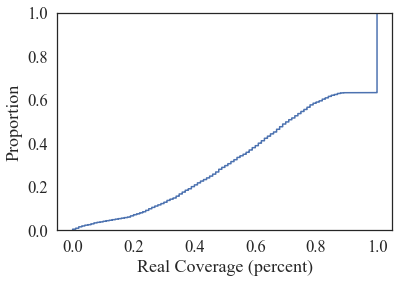

Pearson: 0.8717494904399823
Spearman: 0.9013085623299814
Kendall: 0.730604454510034


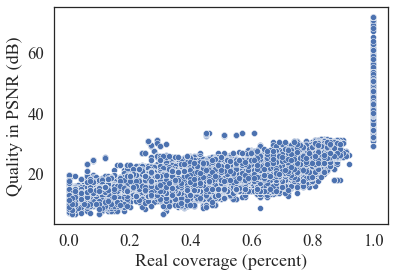

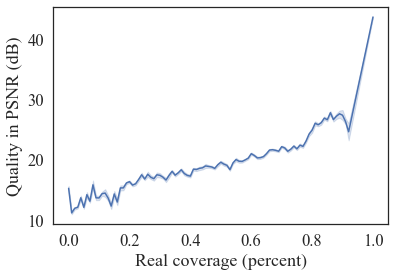

Pearson: 0.8912282249895204
Spearman: 0.9209219059968891
Kendall: 0.7639800461904406


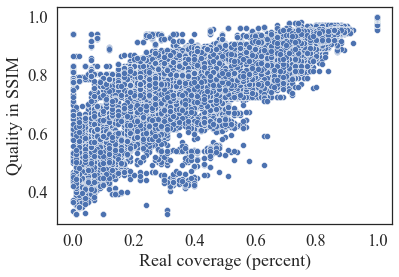

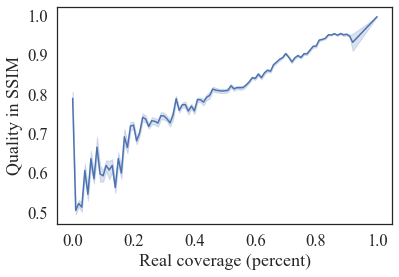

Pearson: 0.9107180069604784
Spearman: 0.9329432858957756
Kendall: 0.7956206319970143


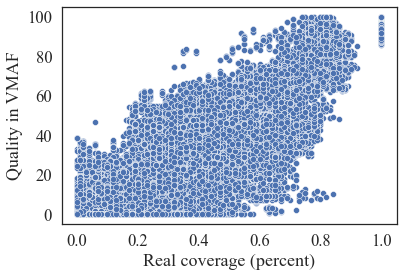

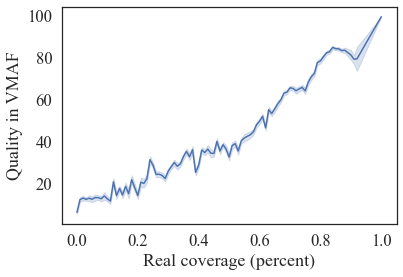

Pearson: -0.8717473483412297
Spearman: -0.901350754074625
Kendall: -0.7320253764213746


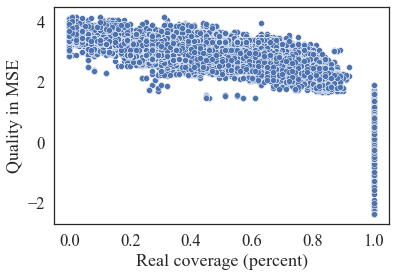

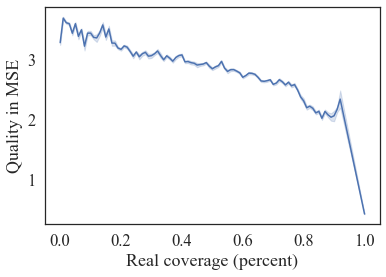

In [44]:
if __name__ == '__main__':
    # resultFilePath = Path('.')/'exp13_coverage'
    # separateAllExpData_withLog(resultFilePath)
    
    coverageResultFilePath = Path('./exp13_coverage_allResults.csv')
    qualityResultFilePath = Path('./exp13_allResults.csv')
    mergeResultFilePath = Path('./exp13_coverage_allResults_merge.csv')
    # merge_results(coverageResultFilePath, qualityResultFilePath)
    
    qualityAndCoverage(mergeResultFilePath)
    
    # allResultFilePathGen = Path('.').glob('*_allResults.csv')
    # allCoverageResultAverage(allResultFilePath)
    
    # allResultFilePath = Path('./exp11_allResults.csv')
    # MSEPlot(allResultFilePath)

    # MSEPlot(mergeResultFilePath)
    # qualityMSEPlot(mergeResultFilePath)
    # newQualityMSEScatterPlot(mergeResultFilePath)